<a href="https://colab.research.google.com/github/krldlamini/edm_brazildengue/blob/main/CCM_Analysis/notebooks/ExtendedCCM_SP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyEDM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 14.8 MB/s eta 0:00:00


In [ ]:
from pyEDM import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib as mpl
import seaborn as sns
sns.set_theme(style='white')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = 'drive/MyDrive/Dengue_BR/Output_Documents/Combined_Files/SP_RDJ_MinMax/355030_A701_combined.csv'
#file_path = 'drive/MyDrive/Dengue_BR/Output_Documents/Combined_Files/SP_RDJ_MinMax/330455_A652_combined.csv'
data_sp = pd.read_csv(file_path, delimiter = ',')

# Drop NAs

In [ ]:
data_sp = data_sp.dropna()

In [ ]:
data_sp_backup = data_sp.copy()
data_sp_backup['month'] = pd.DatetimeIndex(data_sp_backup['data']).month
data_sp = data_sp.drop(columns = ['data'])

In [ ]:
data_sp

,Unnamed: 0,cases,precipitacao_total_horario,temperatura_maxima_na_hora_ant,temperatura_minima_na_hora_ant,umidade_rel_max_na_hora_ant,umidade_rel_min_na_hora_ant
0,0,0,10.2,31.2,18.3,94.0,27.0
1,1,23,50.0,30.0,17.6,95.0,38.0
2,2,28,27.8,30.2,17.8,95.0,39.0
3,3,15,26.6,32.4,17.9,94.0,35.0
4,4,24,149.8,31.8,18.8,96.0,38.0
...,...,...,...,...,...,...,...
776,776,15,8.4,32.2,16.9,89.0,28.0
777,777,25,9.0,33.7,14.0,90.0,14.0
778,778,37,117.4,30.0,17.1,96.0,43.0
779,779,31,15.8,32.2,15.3,92.0,20.0


# Find the right embedding dimension

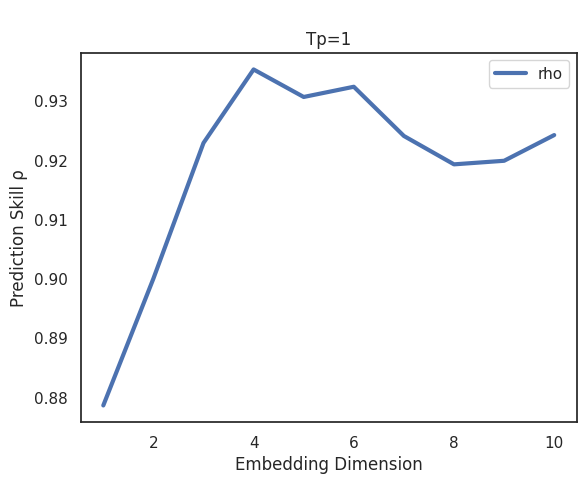

In [ ]:
rho_E = EmbedDimension(dataFrame = data_sp, columns = 'cases',
                        target = 'cases', lib = '1 780',
                        pred = '1 780', showPlot = True)

In [ ]:
rho_E

,E,rho
0,1.0,0.878601
1,2.0,0.900019
2,3.0,0.922919
3,4.0,0.935328
4,5.0,0.930683
5,6.0,0.932407
6,7.0,0.924097
7,8.0,0.919306
8,9.0,0.919910
9,10.0,0.924251


# Doing Extended or Lagged CCM

# Normalizing the data

In [ ]:
data_sp_norm = (data_sp-data_sp.mean())/data_sp.std()

# Calculating interaction strengths (as in the malaria paper)

# Calculating optimal  θ

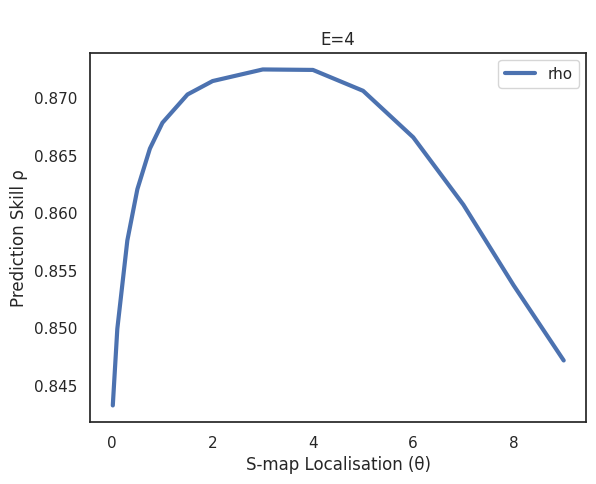

In [ ]:
rho_theta = PredictNonlinear(dataFrame = data_sp_norm, lib = "1 780", pred = "1 780",
target = 'cases', columns = 'cases', E = 4)

In [ ]:
rho_theta[rho_theta['rho'] == max(rho_theta['rho'])]

,Theta,rho
8,3.0,0.872477


# Doing Smap Coefficients

In [ ]:
#precip = np.array(data_sp_norm['precipitacao_total_horario'])
cases = np.array(data_sp_norm['cases'])[7:]
temp_max = np.array(data_sp_norm['temperatura_maxima_na_hora_ant'])[4:-3]
temp_min =  np.array(data_sp_norm['temperatura_minima_na_hora_ant'])[4:-3]

In [ ]:
len(temp_max)

780

In [ ]:
data_sp_smap = pd.DataFrame({'cases':cases, 'temp_max': temp_max, 'temp_min': temp_min})
data_sp_smap = data_sp_smap.reset_index()
smap = SMap(dataFrame = data_sp_smap, lib = "1 773", pred = "1 773", E = 4,
theta = 3, columns = "temp_min temp_max", target = "cases", Tp = 0, embedded = True)

In [ ]:
smap

{'predictions':     index  Observations  Predictions  Pred_Variance
 0       0     -0.246756     0.173717       2.255874
 1       1     -0.198253    -0.121866       1.501268
 2       2     -0.146516     0.127829       1.937618
 3       3     -0.117413     0.196759       2.210010
 4       4     -0.026874     0.016181       1.725507
 ..    ...           ...          ...            ...
 768   768     -0.266157    -0.169318       0.493603
 769   769     -0.249989    -0.270697       0.805300
 770   770     -0.230588    -0.266375       0.968376
 771   771     -0.240289     0.241855       2.292596
 772   772     -0.272624    -0.299199       0.851362
 
 [773 rows x 4 columns],
 'coefficients':     index        C0  ∂cases/∂temp_min  ∂cases/∂temp_max
 0       0  0.840521         -0.416154         -0.203105
 1       1  0.199487          0.510624         -0.540400
 2       2  0.644331         -0.093390         -0.419976
 3       3  0.776670         -0.247297         -0.346425
 4       4  0.578873 

# Plotting the interaction strengths (without colouring by months)

In [ ]:
coefs_maxtemp = smap['coefficients']['∂cases/∂temp_max']
coefs_mintemp = smap['coefficients']['∂cases/∂temp_min']

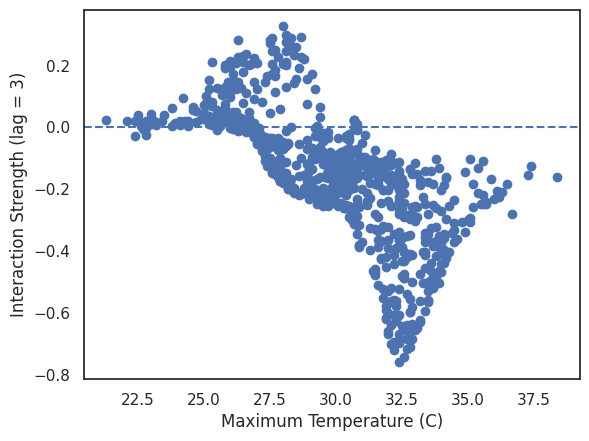

In [ ]:
plt.plot(np.array(data_sp_backup['temperatura_maxima_na_hora_ant'])[4:-3], coefs_maxtemp, 'o')
plt.xlabel('Maximum Temperature (C)')
plt.ylabel('Interaction Strength (lag = 3)')
plt.axhline(0,linestyle = '--')
plt.show()

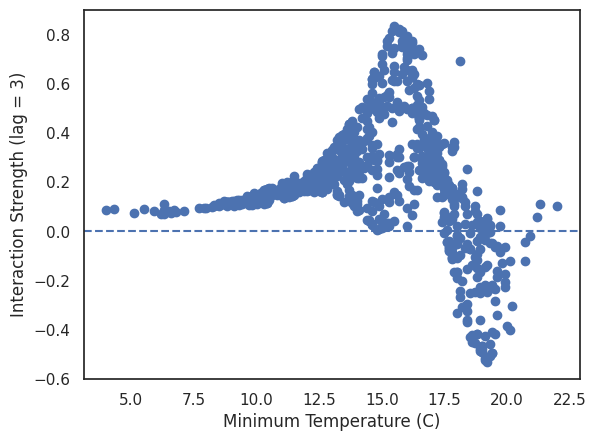

In [ ]:
plt.plot((data_sp['temperatura_minima_na_hora_ant'])[4:-3],coefs_mintemp, 'o')
plt.xlabel('Minimum Temperature (C)')
plt.ylabel('Interaction Strength (lag = 3)')
plt.axhline(0,linestyle = '--')
plt.show()

# Plotting the interaction strengths (colouring by months)

In [ ]:
coefs_maxtemp = smap['coefficients']['∂cases/∂temp_max']
coefs_mintemp = smap['coefficients']['∂cases/∂temp_min']
#coefs_precip = smap['coefficients']['∂cases/∂precip']

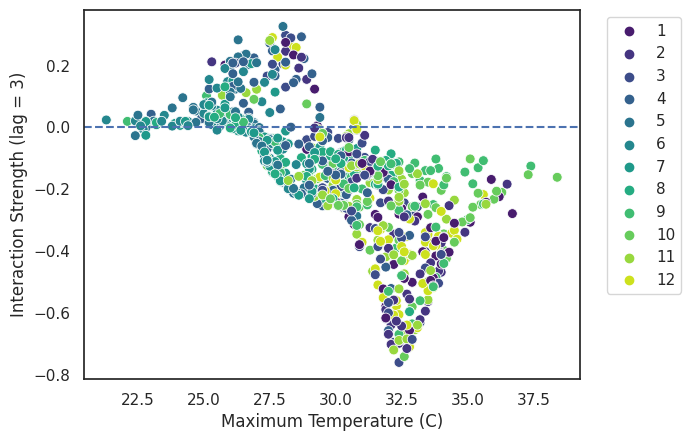

In [ ]:
sns.scatterplot(x = np.array(data_sp['temperatura_maxima_na_hora_ant'])[4:-3], y =coefs_maxtemp, hue = np.array(data_sp_backup['month'])[4:-3], palette = sns.color_palette('viridis',12), s = 50)
plt.xlabel('Maximum Temperature (C)')
plt.ylabel('Interaction Strength (lag = 3)')
plt.axhline(0,linestyle = '--')
plt.legend(bbox_to_anchor=(1.04, 1))
plt.show()

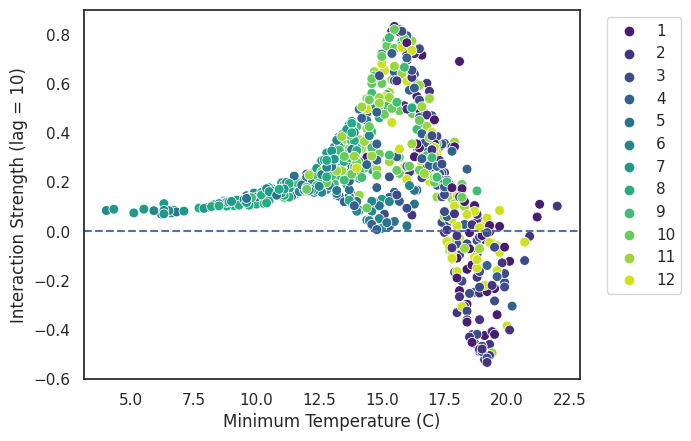

In [ ]:
sns.scatterplot(x = np.array(data_sp['temperatura_minima_na_hora_ant'])[4:-3], y =coefs_mintemp,  hue = np.array(data_sp_backup['month'])[4:-3], palette = sns.color_palette('viridis',12), s = 50)
plt.xlabel('Minimum Temperature (C)')
plt.ylabel('Interaction Strength (lag = 10)')
plt.axhline(0,linestyle = '--')
plt.legend(bbox_to_anchor=(1.04, 1))
plt.show()

# Incorporating precipitation

In [ ]:
precip = np.array(data_sp_norm['precipitacao_total_horario'])[7:-8]
cases = np.array(data_sp_norm['cases'])[15:]
temp_max = np.array(data_sp_norm['temperatura_maxima_na_hora_ant'])[5:-10]
temp_min =  np.array(data_sp_norm['temperatura_minima_na_hora_ant'])[5:-10]

In [ ]:
len(precip)

765

In [ ]:
data_sp_smap = pd.DataFrame({'cases':cases, 'precip': precip,'temp_max': temp_max, 'temp_min': temp_min})
data_sp_smap = data_sp_smap.reset_index()
smap = SMap(dataFrame = data_sp_smap, lib = "1 765", pred = "1 765", E = 4,
theta = 3, columns = "temp_max temp_min precip", target = "cases", Tp = 0, embedded = True)

In [ ]:
smap

{'predictions':     index  Observations  Predictions  Pred_Variance
 0       0      0.322351     0.112903       0.853189
 1       1      0.438759     0.466771       1.706377
 2       2      0.369237     0.614804       1.919756
 3       3      0.311033     0.497638       2.030038
 4       4      0.173607     0.201058       1.165078
 ..    ...           ...          ...            ...
 760   760     -0.266157    -0.333906       0.833408
 761   761     -0.249989     0.043455       1.032681
 762   762     -0.230588    -0.126432       1.003461
 763   763     -0.240289    -0.155309       0.319653
 764   764     -0.272624    -0.279257       0.279080
 
 [765 rows x 4 columns],
 'coefficients':     index        C0  ∂cases/∂temp_max  ∂cases/∂temp_min  ∂cases/∂precip
 0       0 -0.145573          0.110558          0.355151       -0.052012
 1       1 -0.371831          0.356173          0.398472        0.045496
 2       2  0.164973          0.016857         -0.096086        0.243774
 3       3 -0.

In [ ]:
coefs_maxtemp = smap['coefficients']['∂cases/∂temp_max']
coefs_mintemp = smap['coefficients']['∂cases/∂temp_min']
coefs_precip = smap['coefficients']['∂cases/∂precip']

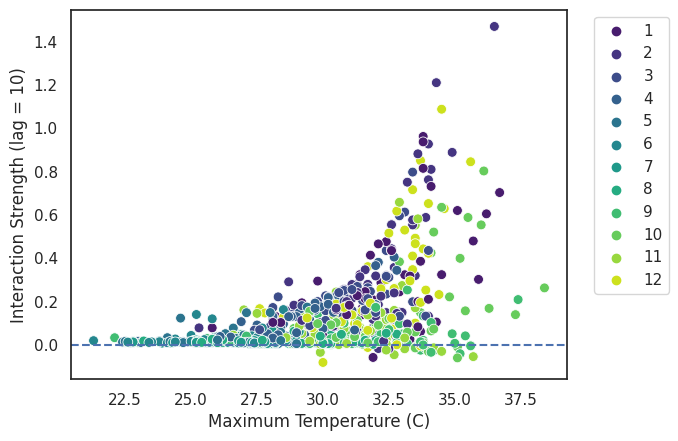

In [ ]:
sns.scatterplot(x = np.array(data_sp['temperatura_maxima_na_hora_ant'])[5:-10], y =coefs_maxtemp, hue = np.array(data_sp_backup['month'])[5:-10], palette = sns.color_palette('viridis',12), s = 50)
plt.xlabel('Maximum Temperature (C)')
plt.ylabel('Interaction Strength (lag = 10)')
plt.axhline(0,linestyle = '--')
plt.legend(bbox_to_anchor=(1.04, 1))
plt.show()

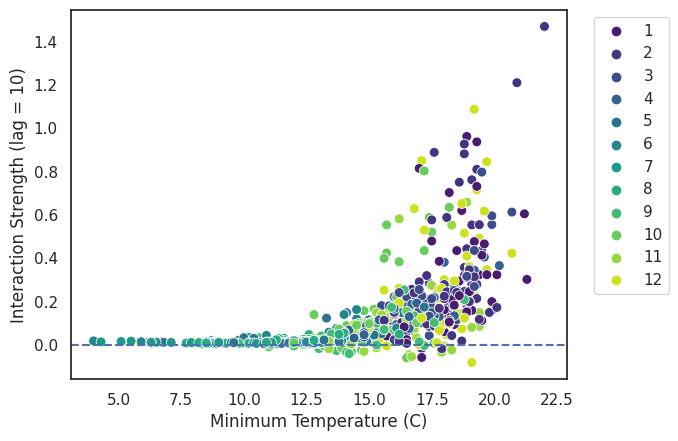

In [ ]:
sns.scatterplot(x = np.array(data_sp['temperatura_minima_na_hora_ant'])[5:-10], y =coefs_maxtemp, hue = np.array(data_sp_backup['month'])[5:-10], palette = sns.color_palette('viridis',12), s = 50)
plt.xlabel('Minimum Temperature (C)')
plt.ylabel('Interaction Strength (lag = 10)')
plt.axhline(0,linestyle = '--')
plt.legend(bbox_to_anchor=(1.04, 1))
plt.show()

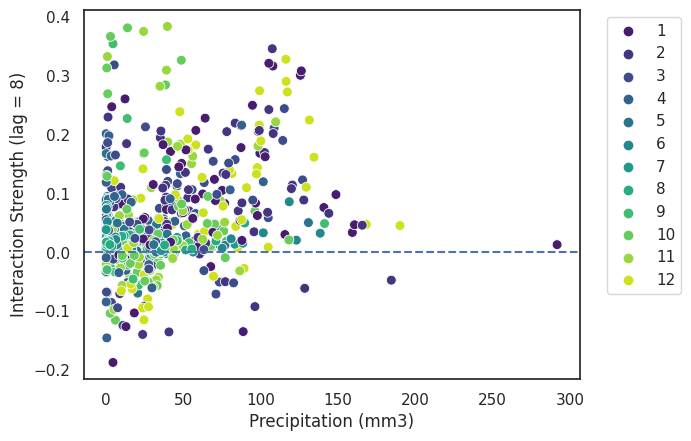

In [ ]:
sns.scatterplot(x = np.array(data_sp['precipitacao_total_horario'])[7:-8], y =coefs_precip,  hue = np.array(data_sp_backup['month'])[7:-8], palette = sns.color_palette('viridis',12), s = 50)
plt.xlabel('Precipitation (mm3)')
plt.ylabel('Interaction Strength (lag = 8)')
plt.axhline(0,linestyle = '--')
plt.legend(bbox_to_anchor=(1.04, 1))
plt.show()